In [3]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [4]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [6]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)

In [8]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [11]:
# Find the most recent date in the data set.
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(f"The most recent date in the datat set is {most_recent_date}")

The most recent date in the datat set is ('2017-08-23',)


2016-08-23


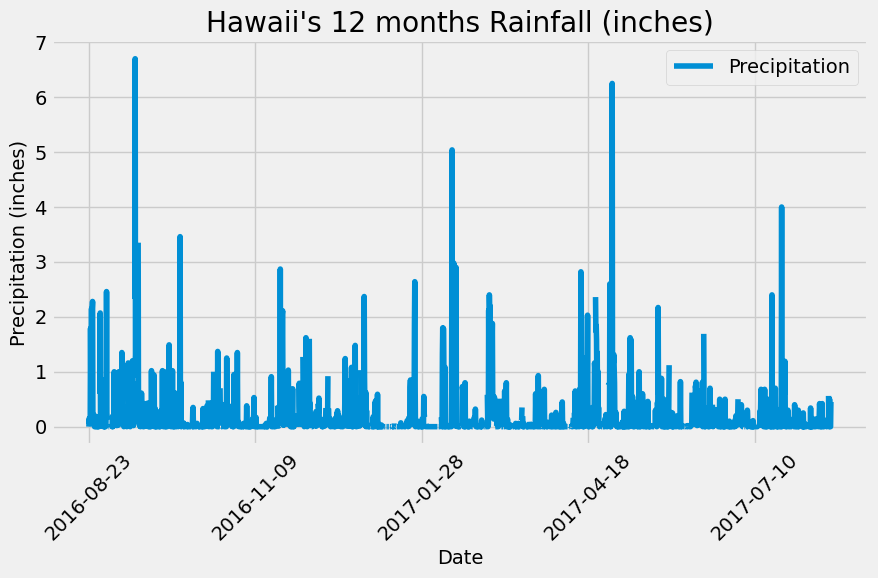

In [17]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

# Calculate the date one year from the last date in data set.
#one_year_prior_date = dt.datetime.strptime(most_recent_date[0],'%Y-%m-%d') - dt.timedelta(days=365)
one_year_prior_date = dt.date(2017,8,23) - dt.timedelta(days=365)
print(one_year_prior_date)

# Perform a query to retrieve the data and precipitation scores
precipitation = session.query(Measurement.date,Measurement.prcp).\
    filter(Measurement.date >= one_year_prior_date).order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(precipitation,columns=['Date','Precipitation'])

# Sort the dataframe by date
precipitation_df = precipitation_df.sort_values('Date')
precipitation_df.head()

# Use Pandas Plotting with Matplotlib to plot the data
graph = precipitation_df.plot(x='Date',y='Precipitation',rot=45,title="Hawaii's 12 months Rainfall (inches)",xlabel='Date',\
                              ylabel='Precipitation (inches)',figsize=(9,6))
plt.tight_layout()
plt.show()
graph.figure.savefig('Hawaii_12_months_precipitation.png',bbox_inches='tight')

In [18]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [20]:
# Design a query to calculate the total number of stations in the dataset
total_number_stations = session.query(func.count(Station.station)).scalar()
total_number_stations

9

In [21]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
most_active_stations = session.query(Measurement.station,func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()
most_active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [22]:
# Which station id has the greatest number of observations?
most_active_station_id = most_active_stations[0][0]
most_active_station_id

'USC00519281'

In [23]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
temperature_summary_statistics = session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).\
    filter(Measurement.station == most_active_station_id).all()
lowest_temperature = temperature_summary_statistics[0][0]
highest_temperature = temperature_summary_statistics[0][1]
average_temperature = temperature_summary_statistics[0][2]

print(f"Temperature Summary Statistics for the Most Active Station (Station ID: {most_active_station_id}):")
print(f"Lowest Temperature: {lowest_temperature} °F")
print(f"Highest Temperature: {highest_temperature} °F")
print(f"Average Temperature: {average_temperature} °F")

Temperature Summary Statistics for the Most Active Station (Station ID: USC00519281):
Lowest Temperature: 54.0 °F
Highest Temperature: 85.0 °F
Average Temperature: 71.66378066378067 °F


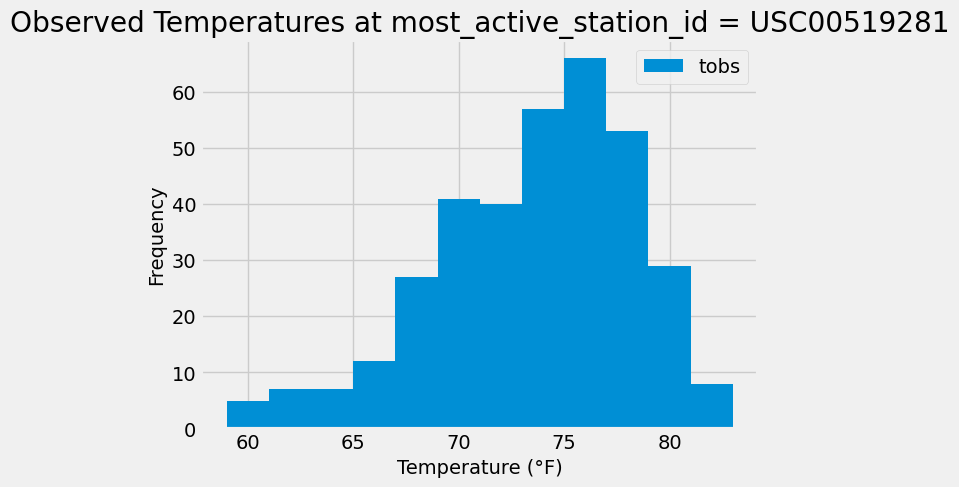

In [24]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
last_12_months = session.query(Measurement.date,Measurement.tobs).\
    filter(Measurement.station == most_active_station_id).\
    filter(Measurement.date >= one_year_prior_date).all()

dates = [result[0] for result in last_12_months]
temperatures = [result[1] for result in last_12_months]

plt.hist(temperatures,bins=12,density=False,label="tobs")
plt.xlabel("Temperature (°F)")
plt.ylabel("Frequency")
plt.legend()
plt.title("Observed Temperatures at most_active_station_id = USC00519281")
plt.figsize=(10,7)
plt.savefig('Observed_Temps_USC00519281')
plt.show()

# Close Session

In [25]:
# Close Session
session.close()